# Main Aggregation Script - calls lab.py and crystals.py

In [156]:
#Reloads the lab.py and crystals.py modules to update any changes (after saving)
#If a new method or object is created, autoreload doesn't work and the 
#kernel needs to be closed and halted after saving and making a 'checkpoint'
#in this notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
#show plots in the notebook, formatting of the plots changes
%matplotlib inline
from ipas import lab_copy_Sconstrain as lab
from ipas import crystals_opt_rot_dendrite as crys
import numpy as np
import time  #for efficiency tests
import itertools   #to create width array and join plate/col aspect ratios
from operator import itemgetter
import shapely.geometry as geom
import matplotlib.pyplot as plt
import scipy.optimize as opt
import random
from shapely.geometry import Point
from pyquaternion import Quaternion

# Two examples that errored


In [231]:
phio=np.logspace(-2, 2, num=50, endpoint=True, base=10.0, dtype=None)#just columns (0,2); plates (-2,0)
#add=np.logspace(-.301, .301, num=5, endpoint=True, base=10.0, dtype=None)
#phio = sorted(np.append(phio, add, axis=0))

#phio = [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1,.2,.3,.4,\
#        .5,.6,.7,.8,.9,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
reqarr = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
#reqarr = [1,2]
numaspectratios=len(phio)
ch_dist='best'         #anything other than gamma uses the characteristic from the best distribution pdf (lowest SSE)
nclusters = 300        #changes how many aggregates per aspect ratio to consider
ncrystals = 2          #number of monomers per aggregate
minor = 'depth'        #'minorxy' from fit ellipse or 'depth' to mimic IPAS in IDL
rand_orient = False     #randomly orient the seed crystal and new crystal: uses first random orientation
save_plots = False     #saves all histograms to path with # of aggs and minor/depth folder
file_ext = 'eps'

#Note, there may be a shape parameter erlang distribution run time warning occasionally if warning filter
#is turned off, disregard it
import warnings
warnings.filterwarnings("ignore")

#If creating lookup table using lab_lookup use this call to main_ar_loop:
#AND change import from lab_copy to lab_lookup in import statement above
#p300lookup = lab.main_ar_loop(phio, reqarr, numaspectratios, ch_dist, nclusters, ncrystals, minor, save_plots, file_ext)
#Otherwise:
testreorhit = lab.main_ar_loop(phio, numaspectratios, ch_dist, nclusters, ncrystals, minor, rand_orient, save_plots, file_ext) 

eq. vol rad 10.0 0.464158883361 46.4158883361 0.01
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12


AttributeError: 'IceCrystal' object has no attribute 'rotation'

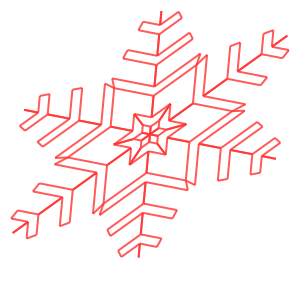

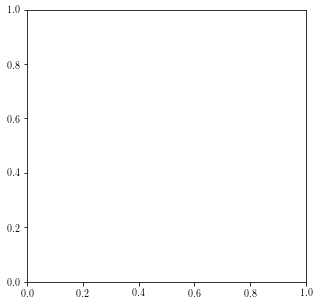

In [243]:
from descartes.patch import PolygonPatch

length=30 * 10 #c axis
width=100 * 10 #a axis
plates = width > length

f = lambda x: -crys.IceCrystal(length=length, width=width, rotation=[0,x,0]).projectxy().area
yrot = opt.minimize_scalar(f, bounds=(0, np.pi/2), method='Bounded').x
f = lambda x: -crys.IceCrystal(length=length, width=width, rotation=[x,0,0]).projectxy().area
xrot = opt.minimize_scalar(f, bounds=(0, np.pi/2), method='Bounded').x

yrotrand = random.uniform(-yrot, yrot)
xrotrand = random.uniform(-xrot, xrot)
rotation = [xrotrand, yrotrand, random.uniform(0, 2 * np.pi)]
#rotation = [0,0,0]
seedcrystal = crys.IceCrystal(length=length, width=width, rotation=rotation)
seedcrystal.rotate_to([np.pi/4,np.pi/7,np.pi/7])

fig = plt.figure(1, figsize=(5,5))
ax = fig.add_subplot(111)

#cluster = crys.IceCluster(seedcrystal)
#ax.plot(seedcrystal.points['x'],seedcrystal.points['y'], seedcrystal.points['z'], 'o',color ='r', linewidth = 3)
def plots():
    lines = []
    for n in range(len(self.pointstop['x'])):
        lines.append(geom.LineString([(seedcrystal.pointstop['x'][n], seedcrystal.pointstop['y'][n], seedcrystal.pointstop['z'][n]),
                                     (seedcrystal.pointsbot['x'][n], seedcrystal.pointsbot['y'][n],seedcrystal.pointsbot['z'][n])]))
    for n in range(len(self.pointsbot['x'])-1):    
        lines.append(geom.LineString([(seedcrystal.pointsbot['x'][n], seedcrystal.pointsbot['y'][n], seedcrystal.pointsbot['z'][n]),
                                     (seedcrystal.pointsbot['x'][n+1], seedcrystal.pointsbot['y'][n+1],seedcrystal.pointsbot['z'][n+1])]))
    for n in range(len(self.pointsbot['x'])-1):    
        lines.append(geom.LineString([(seedcrystal.pointstop['x'][n], seedcrystal.pointstop['y'][n], seedcrystal.pointstop['z'][n]),
                                     (seedcrystal.pointstop['x'][n+1], seedcrystal.pointstop['y'][n+1],seedcrystal.pointstop['z'][n+1])]))
    
    return geom.MultiLineString(lines)
#cryst = plots()  
#for line in cryst:
#    linearray = np.array(line.coords)
#    ax.plot(linearray[:,0].tolist(), linearray[:,1].tolist(), linearray[:,2].tolist(), color='k', linewidth=3)


#cryspatch = PolygonPatch(poly, fill=True, ec='k', fc='k', zorder=1,  alpha=0.9)     
#ax.add_patch(cryspatch)

seedcrystal.plot()


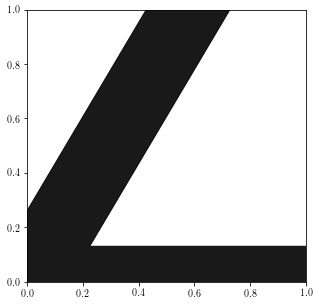

In [187]:
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

xt = []
yt = []
zt = []
xb = []
yb = []
zb = []
for n in range(len(seedcrystal.pointstop['x'])-1):
    xt.append(seedcrystal.pointstop['x'][n])
    yt.append(seedcrystal.pointstop['y'][n])
    zt.append(seedcrystal.pointstop['z'][n])

    xb.append(seedcrystal.pointsbot['x'][n])
    yb.append(seedcrystal.pointsbot['y'][n])
    zb.append(seedcrystal.pointsbot['z'][n])

polygon1 = Polygon([(xt[i],yt[i],zt[i]) for i in range(len(xt))])

polygon2 =Polygon([(xb[i],yb[i],zb[i]) for i in range(len(xb))])
polygons = [polygon1, polygon2]
u = cascaded_union(polygons)

fig = plt.figure(1, figsize=(5,5))
ax = fig.add_subplot(111)
cryspatch = PolygonPatch(u, fill=True, ec='k', fc='k', zorder=1,  alpha=0.9)     
ax.add_patch(cryspatch)


crystal1.8.txt 0.4368482839582902
177128


177184

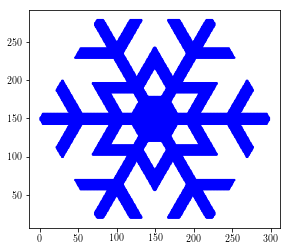

In [220]:
from crystal_dda.crystal_dda import branched_planar_dda
a = 1.8
amax = 3. #max a-axis length of the crystal
ac = 0.4  #a-axis length of the core
fb = 0.3  #area coverage fraction of the sub-branches
ft = 0.3  #fractional width of the crystal tips at amax
fg = 0.7  #fractional distance between ac and amax
nsb = 5
nxp = 300
nzp = 7

fname, afrac = branched_planar_dda(a, amax, ac, ft, fb, fg, nsb, nxp, nzp)
print(fname, afrac)

# plot dipole locations from text file
dda_data = np.genfromtxt(fname, skip_header=3)
x3d = dda_data[:,0]
y3d = dda_data[:,1]
z3d = dda_data[:,2]

# get 2d slice of x y values
zval = z3d[0]
x2d = x3d[z3d==zval]
y2d = y3d[z3d==zval]
plt.scatter(x2d, y2d, c='b', s=5, edgecolor='')
ax = plt.gca()
ax.set_aspect(1.)


[-2.97993311 -2.97993311 -2.97993311 ...,  2.97993311  2.97993311
  2.97993311]


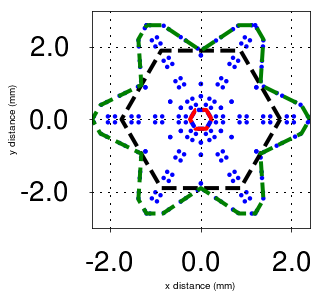

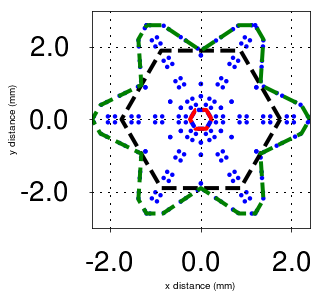

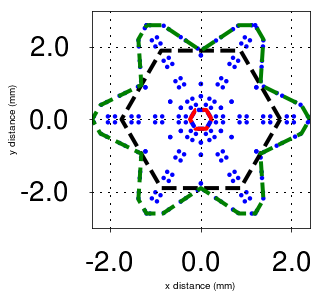

In [59]:
from crystal_dda import polygons as poly
from crystal_dda import geometry as geom
import matplotlib as mpl
mpl.use('Agg')
import warnings
warnings.filterwarnings("ignore")
#import crystal_dda.polygons as poly
#import crystal_dda.geometry as geom

ag = fg*amax+(1.-fg)*ac
wt = ft*amax/2.
xcore, ycore = poly.make_hexagon(ac)
xg, yg = poly.make_hexagon(ag)
xbound = np.array([-amax/2., -amax/2.+wt, 0., amax/2.-wt, amax/2.])
ybound = np.array([np.sqrt(3.)*amax/2., np.sqrt(3.)*amax/2., np.sqrt(3.)*ag/2.,
                   np.sqrt(3.)*amax/2., np.sqrt(3.)*amax/2.])

numxp = 300
numyp = 300
x2d, y2d = np.meshgrid(np.linspace(-amax, amax, numxp),
                       np.linspace(-amax, amax, numyp), indexing='ij')
xp = x2d.flatten()
yp = y2d.flatten()
indicator = np.empty([numxp*numyp])

# create bounding polygons for two regions
xcore, ycore = poly.make_hexagon(ac)
xg, yg = poly.make_hexagon(ag)
xbound = np.array([-amax/2., -amax/2.+wt, 0., amax/2.-wt, amax/2.])
ybound = np.array([np.sqrt(3.)*amax/2., np.sqrt(3.)*amax/2., np.sqrt(3.)*ag/2.,
                   np.sqrt(3.)*amax/2., np.sqrt(3.)*amax/2.])

# rotations for bounding star shape
xboundr, yboundr = geom.rotate(xbound, ybound, -60.)
xbound = np.concatenate((xbound, xboundr[1:]))
ybound = np.concatenate((ybound, yboundr[1:]))

for i in range(4):
    xboundr, yboundr = geom.rotate(xboundr, yboundr, -60.)
    xbound = np.concatenate((xbound, xboundr[1:]))
    ybound = np.concatenate((ybound, yboundr[1:]))

# create branched planar crystal
x, y = poly.make_branched_planar(amax, ac, ft, fb, fg, nsb, 0.)
inbranched = geom.in_polygon(x, y, xp, yp)
xp_br = xp[inbranched]
yp_br = yp[inbranched]

# get crystal shapes at various sizes
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex=True)
numa = 3
avals = np.linspace(ac, amax, numa)

for i, a in enumerate(avals):
    #subset full-size crystal to a size
    xhex, yhex = poly.make_hexagon(a)
    inhex = geom.in_polygon(xhex, yhex, xp_br, yp_br)
    xp_sub = xp_br[inhex]
    yp_sub = yp_br[inhex]

    #plot
    plt.figure(i)
    plt.scatter(x, y, c='b', s=20, edgecolor='')
    plt.plot(xcore, ycore, 'r--', lw=4.)
    plt.plot(xg, yg, 'k--', lw=4.)
    plt.plot(xbound, ybound, 'g--', lw=4.)

    ax = plt.gca()
    ax.set_aspect(1.)
    ax.set_xlim([-amax, amax])
    ax.set_ylim([-amax, amax])

    ax.set_xlabel('x distance (mm)')
    ax.set_ylabel('y distance (mm)')

    ax.tick_params(axis='both', which='major', labelsize=28, pad=20)
    ax.set_xticklabels(ax.get_xticks())
    ax.set_yticklabels(ax.get_yticks())

    ax.grid(color='k', linestyle=(0.5, [2,6]), linewidth=1.)
print(xp_sub)

In [47]:
diplen = 1
xhex, yhex = poly.make_branched_planar(amax, ac, ft, fb, fg, nsb, diplen)
print(len(xhex))

229


[(36.404793810000001, 19.222826449999999), (37.375892489999998, 19.167778080000001), (37.648138299999999, 20.098856439999999), (36.949285430000003, 21.084983179999998), (35.978186739999998, 21.140031539999999), (35.705940929999997, 20.208953180000002), (-59.32836219, -49.063392200000003), (-58.357263500000002, -49.118440569999997), (-58.085017690000001, -48.187362200000003), (-58.783870569999998, -47.20123547), (-59.754969250000002, -47.146187099999999), (-60.027215060000003, -48.07726547)]


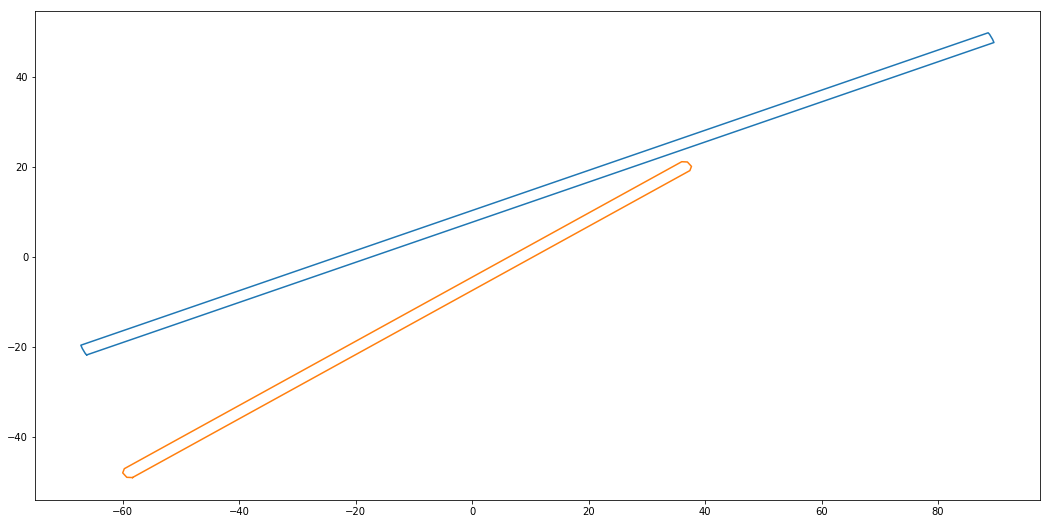

In [6]:
import shapely.ops as shops
#array before aggregate reorientation - intersects fine..
'''
points = np.array([[( 12.60516733,  21.55130144,  67.97918515),
  ( 13.39569662,  20.72361916,  68.36759088),
  ( 12.99916896,  19.68909097,  68.85067553),
  ( 11.81211201,  19.48224506,  68.94535444),
  ( 11.02158272,  20.30992734,  68.55694871),
  ( 11.41811038,  21.34445553,  68.07386407),
  ( 12.87246764, -50.93981505, -87.04149807),
  ( 13.66299693, -51.76749734, -86.65309234),
  ( 13.26646927, -52.80202553, -86.17000769),
  ( 12.07941232, -53.00887144, -86.07532878),
  ( 11.28888303, -52.18118915, -86.46373451),
  ( 11.68541068, -51.14666096, -86.94681915)],
 [( 52.12721762, -26.12203584, -28.5719185 ),
  ( 51.56419959, -26.01529429, -29.63609446),
  ( 50.78175841, -26.86428245, -29.99366746),
  ( 50.56233526, -27.82001215, -29.28706449),
  ( 51.12535328, -27.9267537 , -28.22288853),
  ( 51.90779446, -27.07776554, -27.86531553),
  (-75.24691491,  59.27758214,  47.38320812),
  (-75.80993293,  59.38432369,  46.31903215),
  (-76.59237411,  58.53533554,  45.96145916),
  (-76.81179726,  57.57960583,  46.66806212),
  (-76.24877924,  57.47286429,  47.73223808),
  (-75.46633806,  58.32185244,  48.08981108)]],
    dtype=[('x', float), ('y', float), ('z', float)])
'''
#array after reorientation, crystals no longer intersect

points = np.array([[(-66.2179601 , -21.83987256, -19.56323538),
  (-66.465052  , -21.10710536, -20.4921333 ),
  (-66.96486081, -20.02500149, -20.29189369),
  (-67.21757771, -19.67566482, -19.16275614),
  (-66.9704858 , -20.40843202, -18.23385822),
  (-66.47067699, -21.49053589, -18.43409783),
  ( 89.59665447,  47.65407384,  -6.19001783),
  ( 89.34956256,  48.38684104,  -7.11891576),
  ( 88.84975375,  49.46894491,  -6.91867614),
  ( 88.59703686,  49.81828159,  -5.7895386 ),
  ( 88.84412876,  49.08551439,  -4.86064067),
  ( 89.34393757,  48.00341052,  -5.06088029)],
 [( 36.40479381,  19.22282645, -50.21091545),
  ( 37.37589249,  19.16777808, -49.49342639),
  ( 37.6481383 ,  20.09885644, -48.77243482),
  ( 36.94928543,  21.08498318, -48.76893233),
  ( 35.97818674,  21.14003154, -49.48642139),
  ( 35.70594093,  20.20895318, -50.20741296),
  (-59.32836219, -49.0633922 ,  74.1217063 ),
  (-58.3572635 , -49.11844057,  74.83919537),
  (-58.08501769, -48.1873622 ,  75.56018693),
  (-58.78387057, -47.20123547,  75.56368943),
  (-59.75496925, -47.1461871 ,  74.84620036),
  (-60.02721506, -48.07726547,  74.1252088 )]],
    dtype=[('x', float), ('y', float), ('z', float)])
'''
#same with this example

points = np.array([[( -49.81148038, -53.34538683, -62.57305894),
  ( -50.00569398, -52.29595133, -63.0355414 ),
  ( -50.78148778, -51.57982708, -62.54744935),
  ( -51.36306798, -51.91313833, -61.59687484),
  ( -51.16885438, -52.96257382, -61.13439238),
  ( -50.39306058, -53.67869808, -61.62248443),
  (  83.20472167,  18.19009614,  43.89220962),
  (  83.01050807,  19.23953164,  43.42972716),
  (  82.23471426,  19.95565589,  43.91781921),
  (  81.65313406,  19.62234464,  44.86839372),
  (  81.84734767,  18.57290914,  45.33087618),
  (  82.62314147,  17.85678489,  44.84278413)],
 [(  71.414088  ,   0.55097456, -16.53080805),
  (  71.07475308,  -0.44120861, -17.03414509),
  (  71.05381938,  -1.42802154, -16.41877052),
  (  71.3722206 ,  -1.42265128, -15.30005892),
  (  71.71155552,  -0.4304681 , -14.79672189),
  (  71.73248922,   0.55634482, -15.41209645),
  (-103.21387429,  35.14569347,  33.00472415),
  (-103.55320921,  34.15351029,  32.50138711),
  (-103.57414291,  33.16669737,  33.11676168),
  (-103.25574168,  33.17206763,  34.23547327),
  (-102.91640676,  34.1642508 ,  34.73881031),
  (-102.89547306,  35.15106373,  34.12343574)]],
    dtype=[('x', float), ('y', float), ('z', float)])   
    
points = np.array([[( 33.87502518,  33.51773336,  83.49458544),
  ( 33.07880179,  34.33811054,  83.2802646 ),
  ( 33.29714272,  35.17002872,  82.49721722),
  ( 34.31170703,  35.18156973,  81.92849068),
  ( 35.10793042,  34.36119255,  82.14281152),
  ( 34.88958949,  33.52927437,  82.9258589 ),
  (-39.31826364, -72.19228109, -49.22174383),
  (-40.11448703, -71.37190391, -49.43606467),
  (-39.8961461 , -70.53998573, -50.21911205),
  (-38.88158179, -70.52844473, -50.78783858),
  (-38.0853584 , -71.3488219 , -50.57351775),
  (-38.30369933, -72.18074008, -49.79047037)],
 [(-49.95688294, -52.54823769,  10.79517091),
  (-49.35153984, -52.60681929,  11.78666056),
  (-48.39731244, -53.26917019,  11.84720114),
  (-48.04842813, -53.87293948,  10.91625205),
  (-48.65377123, -53.81435788,   9.92476239),
  (-49.60799864, -53.15200698,   9.86422182),
  ( 53.05498474,  90.88365085, -43.62299891),
  ( 53.66032784,  90.82506924, -42.63150925),
  ( 54.61455524,  90.16271834, -42.57096867),
  ( 54.96343955,  89.55894905, -43.50191776),
  ( 54.35809645,  89.61753066, -44.49340742),
  ( 53.40386905,  90.27988156, -44.55394799)]],
    dtype=[('x', float), ('y', float), ('z', float)])                

'''

xy1 = [(i[0],i[1]) for i in points[0]]
xy2 = [(i[0],i[1]) for i in points[1]]

print(xy2)
fig = plt.figure(figsize=(18,9))
ax = plt.subplot(111)
poly1 = geom.MultiPoint(xy1).convex_hull
poly2 = geom.MultiPoint(xy2).convex_hull

x1, y1 = poly1.exterior.xy
x2, y2 = poly2.exterior.xy
plt.plot(x1,y1)
plt.plot(x2,y2)

